#Importing Data

In [5]:
import pandas as pd
data=pd.read_excel("online_retail_II.xlsx")
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#Cleaning the Data

In [7]:
data=data[data['Customer ID'].notnull()]
data=data[data['Quantity']>0]
data=data[data['Invoice'].astype(str).str.startswith('C')==False]
data['Total Price']=data['Quantity']*data['Price']
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


#RFM metrics

In [10]:
import datetime as dt
snap_data=data['InvoiceDate'].max()+dt.timedelta(days=1)
rfm=data.groupby('Customer ID').agg({'InvoiceDate':lambda x:(snap_data - x.max()).days,'Invoice': 'nunique','Total Price':'sum'})
rfm.columns=['Recency','Frequency','Monetary']
rfm=rfm.reset_index()
print(rfm.head())


   Customer ID  Recency  Frequency  Monetary
0      12346.0      321         12  77556.46
1      12347.0       35          7   5408.50
2      12348.0       71          5   2019.40
3      12349.0       14          4   4428.69
4      12350.0      305          1    334.40


#Assigning RFM scores

In [12]:
print("Scorinng as 1(worst) to 4(best)")
rfm['R_score']=pd.qcut(rfm['Recency'],4, labels=[4,3,2,1])
rfm['F_score']=pd.qcut(rfm['Frequency'].rank(method='first'),4,labels=[1,2,3,4])
rfm['M_score']=pd.qcut(rfm['Monetary'],4,labels=[1,2,3,4])
rfm['RFM_score']=rfm['R_score'].astype(str)+rfm['F_score'].astype(str)+rfm['M_score'].astype(str)
print(rfm.head())

Scorinng as 1(worst) to 4(best)
   Customer ID  Recency  Frequency  Monetary R_score F_score M_score RFM_score
0      12346.0      321         12  77556.46       2       4       4       244
1      12347.0       35          7   5408.50       3       3       4       334
2      12348.0       71          5   2019.40       3       3       3       333
3      12349.0       14          4   4428.69       4       3       4       434
4      12350.0      305          1    334.40       2       1       1       211


In [26]:
#Grouping Customers
def grp_customer(data):
    if data['RFM_score']=='444':
        return 'Best Customers'
    elif data['RFM_score']=='344':
        return 'Frequent Buyers'
    elif data['R_score']=='4':
        return 'very recent customers'
    elif data['RFM_score']=='244':
        return 'New Customers'
    elif data['F_score']=='4'and data['M_score']=='4':
        return 'loyal Customers'
    elif data['M_score']=='4'and data['R_score'] >='2':
        return 'Big Spenders'
    elif data['R_score']=='1':
        return 'At Risk'
    else:
        return 'Others'
rfm['Segment']=rfm.apply(grp_customer,axis=1)
print(rfm.head(10))


   Customer ID  Recency  Frequency  Monetary R_score F_score M_score  \
0      12346.0      321         12  77556.46       2       4       4   
1      12347.0       35          7   5408.50       3       3       4   
2      12348.0       71          5   2019.40       3       3       3   
3      12349.0       14          4   4428.69       4       3       4   
4      12350.0      305          1    334.40       2       1       1   
5      12351.0      370          1    300.93       2       1       1   
6      12352.0       31         10   2849.84       3       4       4   
7      12353.0      199          2    406.76       2       2       2   
8      12354.0      228          1   1079.40       2       1       3   
9      12355.0      209          2    947.61       2       2       3   

  RFM_score          Segment  
0       244    New Customers  
1       334           Others  
2       333           Others  
3       434           Others  
4       211           Others  
5       211          

#Visualize Segments

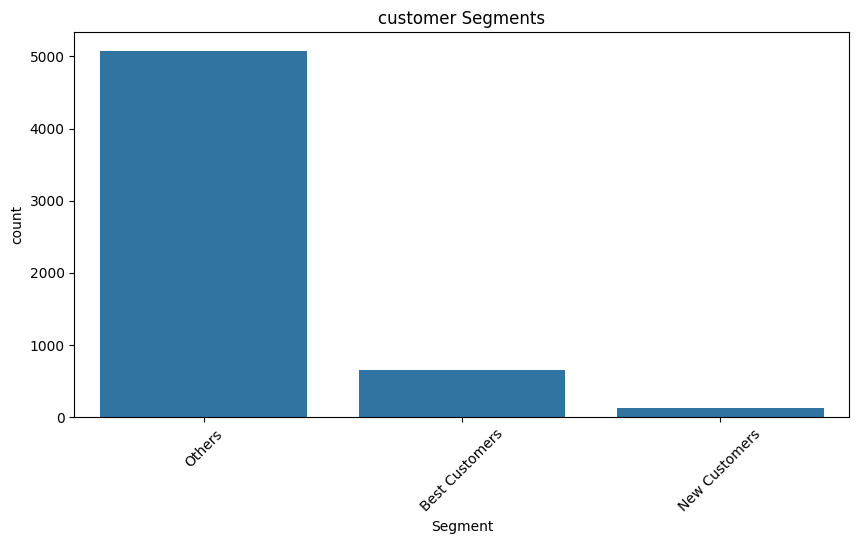

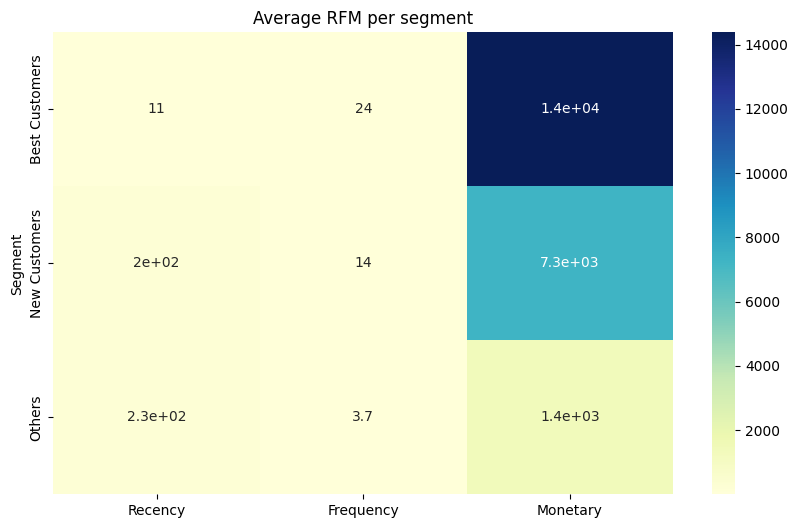

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='Segment',data=rfm,order=rfm['Segment'].value_counts().index)
plt.title("customer Segments")
plt.xticks(rotation=45)
plt.show()
#Heat map of mean values per segment
segment_summary=rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().round(1)
plt.figure(figsize=(10,6))
sns.heatmap(segment_summary,annot=True,cmap='YlGnBu')
plt.title("Average RFM per segment")
plt.show()

In [27]:
#exporting data to excel
rfm.to_excel("RFM_Segments.xlsx",index=False)